# testing of semantic search model

## test datasets

- MS Macro [github](https://github.com/microsoft/MSMARCO-Passage-Ranking)
    - passage ranking
- GLUE
    - evaluates if a given content gives an answer to a question
- XTREME

MRR could be useful to evaluate a ranking for its correctness

In [1]:
import pandas as pd

In [2]:
db_passages = pd.read_csv('~/datasets/ms_marco/collection.tsv', sep='\t', names=['id', 'text'])

In [3]:
len(db_passages)

8841823

In [2]:
db_top1000 = pd.read_csv('~/datasets/ms_marco/top1000.dev', sep='\t', names=['qid', 'pid', 'query', 'passage'])


In [4]:
len(db_top1000.pid.unique())

3895239

In [5]:
db_top1000.qid.unique()[:5]

array([ 188714, 1082792,  995526,  199776,  660957])

In [3]:
db_top1000.pid.unique()
db_passages = db_top1000['pid', 'passage']

KeyError: ('pid', 'passage')

In [5]:
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('paraphrase-distilroberta-base-v1')

In [3]:
query_data = db_top1000[db_top1000.qid == db_top1000.qid.unique()[0]]

my_query = query_data['query'].iloc[0]

In [6]:
query_embeddings = embedder.encode(my_query, convert_to_tensor=True)
print("Done, got query embeddings with len {} for query {}".format(len(query_embeddings), my_query))

Done, got query embeddings with len 768 for query foods and supplements to lower blood sugar


In [7]:
query_data.passage

0          Watch portion sizes: ■ Even healthy foods will...
2112       Cinnamon, people who have diabetes, is commonl...
4854       Most foods that lower blood sugar have fat con...
8856       Your doctor will also give you a list of foods...
9385       Plantains can raise blood sugar levels. Any fo...
                                 ...                        
6636555    This food has a average quantity of sugar comp...
6637370    Over time I learned how to keep my blood sugar...
6655836    Check to see how exercise affects blood sugar ...
6659247    Low Glycemic. With a glycemic index of 3, coco...
6663551    Pick one to two supplements at a time to track...
Name: passage, Length: 1000, dtype: object

In [8]:
passage_embeddings = embedder.encode(query_data.passage.values, convert_to_tensor=True)
print("Done, got passage embeddings with len {}".format(len(passage_embeddings)))

Done, got passage embeddings with len 1000


In [50]:
# get cos sim for each passage to query
from sentence_transformers import util
import torch

cos_scores = util.pytorch_cos_sim(query_embeddings, passage_embeddings)[0]
top_results = torch.topk(cos_scores, k=1000)

In [ ]:
print("\n\n======================\n\n")
print("Query:", my_query)
print("\nTop 5 most similar sentences in corpus:")

for score, idx in zip(top_results[0], top_results[1]):
    print(query_data['passage'].iloc[idx.numpy()], "(Score: {:.4f})\n".format(score))

In [17]:
db_qrels = pd.read_csv('~/datasets/ms_marco/qrels.dev.tsv', sep='\t', names=['qid', 'ignore1', 'pid', 'ignore2'])

In [18]:
query_revelant_passage = db_qrels[db_qrels.qid == db_top1000.qid.unique()[0]]

In [31]:
query_revelant_passage

,qid,ignore1,pid,ignore2
58959,188714,0,8003843,1
58960,188714,0,4321745,1
58961,188714,0,8003849,1


In [26]:
query_revelant_passage.pid.values

array([8003843, 4321745, 8003849])

In [36]:
query_data.passage[query_data.pid == 4321745].values

array(['Food And Supplements That Lower Blood Sugar Levels. Cinnamon: Researchers are finding that cinnamon reduces blood sugar levels naturally when taken daily. If you absolutely love cinnamon you can sprinkle the recommended six grams of cinnamon on your food throughout the day to achieve the desired effect.'],
      dtype=object)

In [51]:
query_score = 0
for count, (score, idx) in enumerate(zip(top_results[0], top_results[1])):
    passage_id = query_data['pid'].iloc[idx.numpy()]
    #print(passage_id)
    query_relevant_pids = query_revelant_passage.pid.values
    if passage_id in query_relevant_pids:
        query_score += (1/(count+1))
print(query_score)

0.008667247386759582


In [14]:
query_data['passage'].iloc[7]

'Foods that lower blood sugar levels should be integrated into a healthy diet as well as kept handy for times when blood sugar elevates. Most foods that lower blood sugar have fat content. According to WebMD, good fats lower insulin resistance. When cells are more sensitive to insulin, blood sugar levels drop.'

---


In [9]:
data_queries = pd.read_csv('~/datasets/ms_marco/orcas-doctrain-queries.tsv', sep='\t', names=['id', 'query'])
data_qrels = pd.read_csv('~/datasets/ms_marco/orcas-doctrain-qrels.tsv', sep='\t', names=['qid','ignore1','pid','ignore2'])

In [10]:
data_queries.head()

,id,query
0,9265503,github
1,6832981,youtube
2,9571352,!
3,4896888,! c
4,10001890,! c++


In [11]:
data_qrels.head()

,9265503 0 D1265400 1
0,9265503 0 D3438005 1
1,6832981 0 D2923232 1
2,9571352 0 D1238374 1
3,9571352 0 D889000 1
4,9571352 0 D291024 1


## PCA

In [1]:
from evaluate_model import EvaluateModel

In [2]:
evaluation = EvaluateModel()

Starting test of test.hdf5
/home/kilian/projects/SISSI/models/test.hdf5


In [3]:
cos_similarities = evaluation.get_cosine_similarities()

In [4]:
print(type(cos_similarities))

<class 'dict'>


In [1]:
# pca https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(
    f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}"
)

# digits: 10; # samples: 1797; # features 64


In [2]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(data, estimator[-1].labels_,
                                 metric="euclidean", sample_size=300,)
    ]

    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4,
                random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * '_')

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	1.045s	69485	0.613	0.660	0.636	0.482	0.632	0.160
random   	0.173s	69952	0.545	0.616	0.578	0.415	0.574	0.137
PCA-based	0.132s	72686	0.636	0.658	0.647	0.521	0.643	0.139
__________________________________________________________________________________


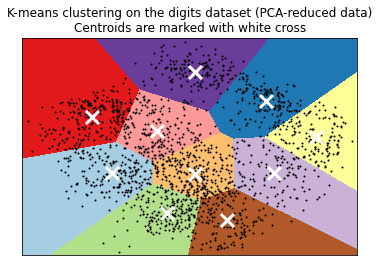

In [4]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("K-means clustering on the digits dataset (PCA-reduced data)\n"
          "Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()